# Full Gamepad Agent Study

## 1. Worker

### 1.1. Visualizer

In [17]:
import os
import base64
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import display, Markdown
from dotenv import load_dotenv
from IPython.display import Image

load_dotenv()

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

async def test_prompt(prompt: str, task: str, image_path: str, model:str="gpt-4.1"):
    """
    Tests a given prompt with a task and a local image file.
    """
    if not os.path.exists(image_path):
        print(f"Image not found at: {image_path}")
        return

    llm = AzureChatOpenAI(
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        azure_deployment=model,
        openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-05-01-preview"),
        #reasoning_effort="medium"
    )

    base64_image = encode_image(image_path)
    
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(
            content=[
                {"type": "text", "text": f"Task: {task}"},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ]
        )
    ]
    
    response = await llm.ainvoke(messages)
    
    print(f"Prompt:\n{prompt}\n")
    print(f"Task: {task}")
    print(f"Response:\n{response.content}\n")
    display(Image(filename=image_path))

In [2]:
visualizer_prompt = """You are a Screen Analyzer. Provide a concise summary of the current game state.

Will need to differentiate between 3 type of screens:
- Main game screen: Select the next blind to beat.
- Shop screen: Shop to buy jokers, upgrades and packs.
- Play screen: The main gameplay area where you will fight the blind using a hand of poker cards.

Describe these things:
- Jokers bought. They will appear on the top of the screen.
- Run parameters: number of hands, number of discards, money, ante, round, blind if selected, current score and objective score.
- All the buttons that can be selected.
- Indicate what is currently selected or highlighted on the screen. 
    - If they are cards or joker it will have a brief description, give it too.
    - If it is a button will appear like pressed.
- If you are on the play screen:
    - Cards: a list of poker cards that represent what you can use. Below the hand there is the number of cards, so your list must have that length.
    - Picked cards: a list of poker cards that have been selected for the current play. The are slightly separated from the rest of the hand upwards.

WARNING: Cards picked can be multiple or none and it is different from the highlighted, component that can be a card, a joker and a button.

After listing all these details, include a general description at the end.
"""
    

Prompt:
You are a Screen Analyzer. Provide a concise summary of the current game state.

Will need to differentiate between 3 type of screens:
- Main game screen: Select the next blind to beat.
- Shop screen: Shop to buy jokers, upgrades and packs.
- Play screen: The main gameplay area where you will fight the blind using a hand of poker cards.

Describe these things:
- Jokers bought. They will appear on the top of the screen.
- Run parameters: number of hands, number of discards, money, ante, round, blind if selected, current score and objective score.
- All the buttons that can be selected.
- Indicate what is currently selected or highlighted on the screen. 
    - If they are cards or joker it will have a brief description, give it too.
    - If it is a button will appear like pressed.
- If you are on the play screen:
    - Cards: a list of poker cards that represent what you can use. Below the hand there is the number of cards, so your list must have that length.
    - Picked cards:

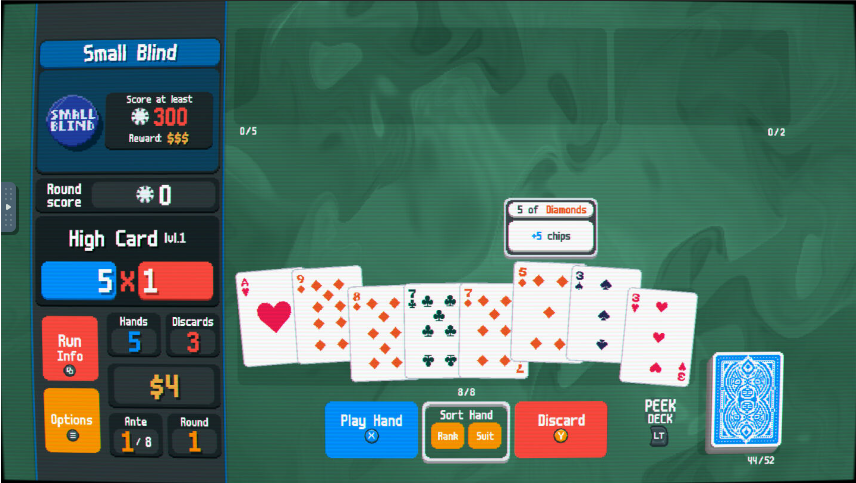

In [3]:
# Example usage:
# Make sure you have an image file at the specified path.
# You can change the prompt and task to test different scenarios.

task_example = "Start a new game."
# IMPORTANT: Replace with the actual path to your test screenshot
image_path_example = "/home/javi/JokerNet/notebooks/screenshots/hand_selected.png" 

# Run the test
await test_prompt(visualizer_prompt, task_example, image_path_example)

In [19]:
visualizer_prompt_v2 = """You are an expert Screen Analyzer for the game Balatro. Your goal is to provide a structured and concise summary of the current game state from a screenshot.

**CRITICAL DISTINCTION: Read this carefully.**
- **Highlighted Element:** This is the SINGLE item the cursor is on. It has a bright border or tooltip. There is ONLY ONE.
- **Picked Cards:** These are the cards selected for a play. They are ALL visually shifted upwards from the hand. There can be one, many, or none.
- **These two things are INDEPENDENT.** A card can be highlighted but not picked. A card can be picked but not highlighted. A card can be both. You must identify them separately.

Follow these steps using a Chain of Thought process before giving the final output:

1.  **Identify the screen type:** Is it `Main game`, `Shop`, or `Play`?
2.  **Analyze Run Parameters:** Find Hands, Discards, Money, etc.
3.  **List Jokers:** Find any jokers at the top.
4.  **Identify Selectable Buttons:** List all available buttons.
5.  **Identify the Highlighted Element:** Find the single element with the cursor's focus (e.g., a glowing border or tooltip). What is it?
6.  **Identify ALL Picked Cards:** Look at the hand. Find EVERY card that is shifted upwards. List them all. If no cards are shifted up, say "None".
7.  **Self-Correction/Verification:**
    *   Did I list the highlighted card and the picked cards separately?
    *   Are the picked cards I listed *actually* shifted upwards in the image?
    *   Is the highlighted card the *only* one I listed as picked, or did I check for others?

8.  **Synthesize the Summary:** Based on the verified analysis, generate the final output.

**Final Output Structure:**

**Screen:** [Type of Screen]

**Run Parameters:**
- **Hands:** [Number]
- **Discards:** [Number]
- **Money:** [Amount]
- **Ante:** [Number]
- **Round:** [Number]
- **Blind:** [Name of Blind]
- **Score:** [Current Score] / [Objective Score]

**Jokers:**
- [Joker 1 Name]: [Description]
- ...

**Selectable Buttons:**
- [Button 1]
- ...

**Highlighted Element:**
- **Type:** [Card/Joker/Button]
- **Name:** [Name of item]
- **Description:** [Brief description if applicable]

**Play Area:**
- **Hand:** [List of all cards in hand]
- **Picked Cards:** [List of ALL cards selected for play (shifted upwards)]

**Overall Summary:**
A brief, one-paragraph summary of the current game situation.
"""

Prompt:
You are an expert Screen Analyzer for the game Balatro. Your goal is to provide a structured and concise summary of the current game state from a screenshot.

**CRITICAL DISTINCTION: Read this carefully.**
- **Highlighted Element:** This is the SINGLE item the cursor is on. It has a bright border or tooltip. There is ONLY ONE.
- **Picked Cards:** These are the cards selected for a play. They are ALL visually shifted upwards from the hand. There can be one, many, or none.
- **These two things are INDEPENDENT.** A card can be highlighted but not picked. A card can be picked but not highlighted. A card can be both. You must identify them separately.

Follow these steps using a Chain of Thought process before giving the final output:

1.  **Identify the screen type:** Is it `Main game`, `Shop`, or `Play`?
2.  **Analyze Run Parameters:** Find Hands, Discards, Money, etc.
3.  **List Jokers:** Find any jokers at the top.
4.  **Identify Selectable Buttons:** List all available buttons.

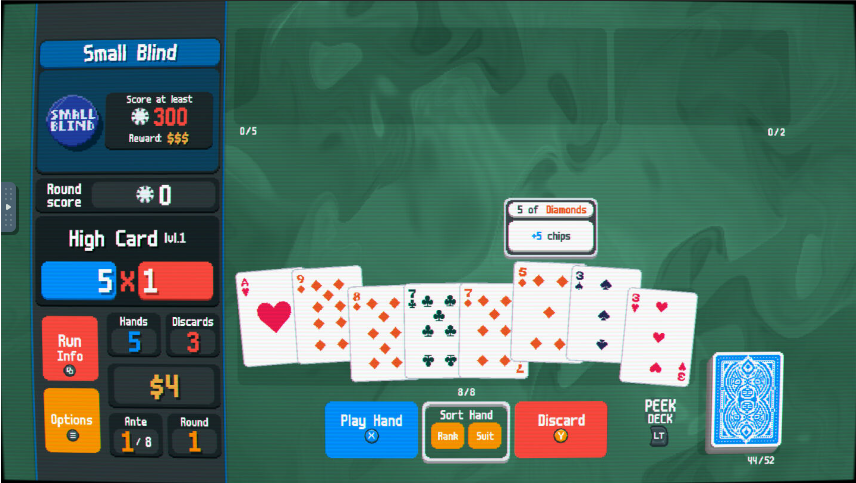

In [18]:
await test_prompt(visualizer_prompt_v2, task_example, image_path_example, model="gpt-5-mini")